<center><h1>Backpropagation From Scratch in PyTorch</h1></center>

---

# 1. Loading Data

In [2]:
%matplotlib inline

In [3]:
import torch
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

digits = load_digits()

In [4]:
X = torch.tensor(digits["images"]).float()
Y = torch.tensor(digits["target"]).long()

print(f"Images shape: {X.shape}, targets shape: {Y.shape}")

Images shape: torch.Size([1797, 8, 8]), targets shape: torch.Size([1797])


We have 1797 images, each of size 8x8. The targets shape is 1797 because, for each image a target is simply an integer representing the digit.

Now that our data is loaded, we need to visualize it.

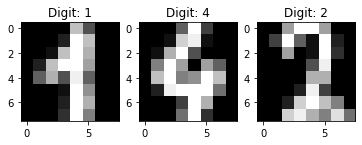

In [5]:
plt.subplot(1, 3, 1)
plt.imshow(X[42], cmap="gray")
plt.title(f"Digit: {Y[42]}");

plt.subplot(1, 3, 2)
plt.imshow(X[64], cmap="gray")
plt.title(f"Digit: {Y[64]}");

plt.subplot(1, 3, 3)
plt.imshow(X[1337], cmap="gray")
plt.title(f"Digit: {Y[1337]}");

For this dataset, the pixels are coded with 4 bits, meaning that we can have values from 0 to 16 ($2^4$).

In [6]:
print(f"Min and max value of images pixels [{X.min()}, {X.max()}]")
X = X / 16
print(f"Min and max value of normalized images pixels [{X.min()}, {X.max()}]")

Min and max value of images pixels [0.0, 16.0]
Min and max value of normalized images pixels [0.0, 1.0]


MLP only accepts inputs that are vectors, thus we will flatten our images into vectors:

In [7]:
# Flatten images as vectors
print(f"Images shape: {X.shape}")
X = X.view(X.shape[0], -1)
print(f"Flatten images shape: {X.shape}")

Images shape: torch.Size([1797, 8, 8])
Flatten images shape: torch.Size([1797, 64])


---

# 2. Activation Functions

Now that the data is loaded and preprocessed, we need to code the non-linear activation functions that are essential to deep learning.

Let's start by `softmax`, the final activation, that will give us a probability per digit. It takes as input a vector of **logits** (the final outputs of the network before softmax, one value per digit) and returns a vector of probabilities.

Here is the formula for the $i^\text{th}$ probability:

$$\text{softmax}(\mathbf{x})_i = \frac{e^{x_i}}{\sum_j e^{x_j}}$$
$$\operatorname{softmax}(\mathbf{x} - c)_i = \frac{e^{x_i - c}}{\sum_j e^{x_j - c}}$$
$$\operatorname{softmax}(\mathbf{x} - c)_i = \frac{e^{-c} e^{x_i}}{e^{-c} \sum_j e^{x_j}}$$
$$\operatorname{softmax}(\mathbf{x} - c)_i = \frac{e^{x_i}}{\sum_j e^{x_j}}$$
$$\operatorname{softmax}(\mathbf{x} - c)_i = \operatorname{softmax}(\mathbf{x})_i$$



In [8]:
def softmax(x):
  maximum_value = x.max(dim=1, keepdims=True)[0]
  exp = torch.exp(x - maximum_value)
  soft = exp / torch.sum(exp, dim=1, keepdims=True)
  return torch.nan_to_num(soft, 1)

In [9]:
def cross_entropy(probs, targets):
  return - torch.sum(targets * torch.log(probs + 1e-8), dim=1)

---

# 3. Logistic Regression

Here is the forward formula:

$$\tilde{\mathbf{y}} = \mathbf{X}\mathbf{W} + \mathbf{b}$$
$$\hat{\mathbf{y}} = \text{softmax}(\tilde{\mathbf{y}})$$
$$\mathcal{L} = -\frac{1}{B} \sum_{b=1}^B \log \hat{\mathbf{y}}_y $$

With $\mathbf{X} \in \mathbb{R}^{B \times N}$, $\mathbf{W} \in \mathbb{R}^{N \times C}$, and $\mathbf{b} \in \mathbb{R}^{C}$. With $B$ being the batch size, $N$ the number of input pixels, and $C$ the number of classes.

For the backward, We can simplify formulas with a shortcut by taking directly the gradient of the loss $\mathcal{L}$ with relation to (w.r.t) the logits $\tilde{\mathbf{y}}$ (*see course for details*):

$$\nabla_\tilde{\mathbf{y}} \mathcal{L} = \hat{\mathbf{y}} - \mathbf{y}$$

Only two gradients are of interest: the one with relation to (w.r.t) the weights $\mathbf{W}$ and $\mathbf{b}$, the neurons we want to update. 

$$\nabla_\mathbf{W} \mathcal{L} = (\nabla_\mathbf{W} \tilde{\mathbf{y}})^T \nabla_\tilde{\mathbf{y}} \mathcal{L}$$
$$\nabla_\mathbf{b} \mathcal{L} = \nabla_\tilde{\mathbf{y}} \mathcal{L}$$



In [10]:
class LogisticRegression:
    def __init__(self, input_size, nb_classes, learning_rate=0.5):
        self.w =  torch.randn(input_size, nb_classes).float()
        self.b =  torch.randn(nb_classes).float()

        self.learning_rate = learning_rate
        
    def forward(self, x):
        return torch.matmul(x, self.w) + self.b
    
    def fit(self, inputs, targets, train=True):
        probs = softmax(self.forward(inputs))
        if train:
          self.backward(inputs, probs, targets)

        loss = cross_entropy(probs, torch.eye(10)[targets]).mean()
        return loss
    
    def backward(self, inputs, probs, targets):
        batch_size = len(inputs)

        grad_logits = probs - torch.eye(self.b.shape[0])[targets]
        grad_w = torch.mm(inputs.T, grad_logits) / batch_size
        grad_b = torch.sum(grad_logits, dim=0) / batch_size

        self.w = self.w - self.learning_rate * grad_w
        self.b = self.b - self.learning_rate * grad_b
        
    def accuracy(self, inputs, targets):
        y_pred = self.forward(inputs).argmax(dim=1)
        return torch.mean((y_pred == targets).float())
             

# 4. Training

**Note** that we are training and testing on the same set here for simplicity.

Epoch: 0, loss: 0.9359496235847473, accuracy: 0.7167501449584961
Epoch: 1, loss: 0.5265157222747803, accuracy: 0.8525319695472717
Epoch: 2, loss: 0.390424907207489, accuracy: 0.8887034058570862
Epoch: 3, loss: 0.3199089467525482, accuracy: 0.9120756983757019
Epoch: 4, loss: 0.2762351930141449, accuracy: 0.9287701845169067
Epoch: 5, loss: 0.2463350147008896, accuracy: 0.9376739263534546
Epoch: 6, loss: 0.22446675598621368, accuracy: 0.9426822662353516
Epoch: 7, loss: 0.20769262313842773, accuracy: 0.9454646706581116
Epoch: 8, loss: 0.19435009360313416, accuracy: 0.9493600726127625
Epoch: 9, loss: 0.18342824280261993, accuracy: 0.9510294795036316


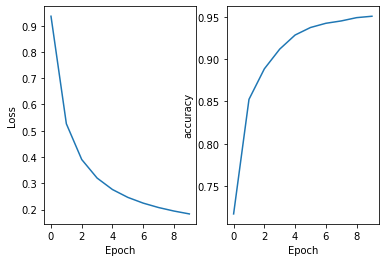

In [11]:
model = LogisticRegression(X.shape[1], len(torch.unique(Y)), 0.5)

batch_size = 32
nb_epochs = 10

epochs, accuracies, losses = [], [], []

for epoch in range(nb_epochs):
    for batch_index in range(0, len(X), batch_size):
        batch_X = X[batch_index:batch_index + batch_size]
        batch_Y = Y[batch_index:batch_index + batch_size]
    
        loss = model.fit(batch_X, batch_Y)
        
    loss = model.fit(X, Y, train=False)
    acc = model.accuracy(X, Y)
    
    print(f"Epoch: {epoch}, loss: {loss}, accuracy: {acc}")
    epochs.append(epoch)
    losses.append(loss)
    accuracies.append(acc)
    
plt.subplot(1, 2, 1)
plt.plot(epochs, losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies)
plt.xlabel("Epoch")
plt.ylabel("accuracy");